In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Preprocess Data

In [188]:
def load_image(imagepath):
    imagepath = imagepath.replace(' ', '')
    #image = np.array(Image.open(imagepath))
    image = cv2.imread(imagepath)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    return image

def resize_image(image):
    img_rows, img_cols = 64, 64
    shape = image.shape
    # Crop top and remove hood
    image = image[math.floor(shape[0]/5):shape[0] - 25:,:]
    # Resize to 64 x 64
    image = cv2.resize(image, (img_rows, img_cols), interpolation=cv2.INTER_AREA)
    return image

def augment_brightness(image):
    new_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    random_brightness = 0.25 + np.random.uniform()
    new_image[:,:,2] = new_image[:,:,2] * random_brightness
    new_image = cv2.cvtColor(new_image, cv2.COLOR_HSV2RGB)
    return new_image
    
def augment_trans_shifts(image, steer, trans_range):
    rows, cols, ch = image.shape
    x_translation = trans_range * np.random.uniform() - trans_range / 2
    steer_angle = steer + x_translation / trans_range * 2 * 0.2
    y_translation = 40 * np.random.uniform() - 40 / 2
    
    m_translation = np.float32([[1, 0, x_translation], [0, 1, y_translation]])
    image_trans = cv2.warpAffine(image, m_translation, (cols, rows))
    return image_trans, steer_angle

In [3]:
input_file = pd.read_csv('driving_log.csv')
input_file = input_file
steering_angle = input_file['steering']

0.1712541


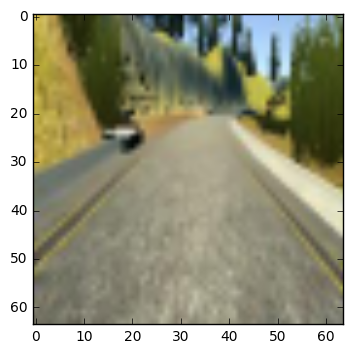

In [190]:
def preprocess(input_files):
    position = np.random.choice(['center', 'left', 'right'])#, p = [0.40, 0.10, 0.50])
    idx = np.random.randint(len(input_files))
    image_path = input_file[position][idx]
    if position == 'left':
        shift_angle = 0.25
    elif position == 'right':
        shift_angle = -0.25
    else:
        shift_angle = 0.

    image = load_image(image_path)
    steer_angle = input_file['steering'][idx] + shift_angle        
    
    #image = augment_brightness(image)
    #image, steer_angle = augment_trans_shifts(image, steer_angle, 70)
    image = resize_image(image)
    
    if np.random.randint(2) == 0:
        image = cv2.flip(image, 1)
        steer_angle = -steer_angle
    
    return image, steer_angle

def generate_data(input_file):
    img_rows, img_cols = 64, 64
    features = np.zeros((1, 64, 64, 3))
    label = np.zeros(1)
    while True:
        X, y = preprocess(input_file)
        X = X.reshape(1, img_rows, img_cols, 3)
        features[0] = X
        label[0] = y
        yield X, label
        
test,y = preprocess(input_file)
plt.imshow(test)
print(y)

### Build Model

In [192]:
from keras.layers.core import Dense, Activation, Flatten, Dropout, Reshape, Lambda
from keras.activations import relu, softmax
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Convolution2D
from keras.models import Sequential

model = Sequential()
model.add(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', input_shape=(64, 64, 3)))

model.add(Lambda(lambda x: x / 255. - 0.5))

model.add(Convolution2D(24, 5, 5, border_mode='same'))
model.add(Activation('relu'))

model.add(Convolution2D(36, 5, 5, border_mode='same'))
model.add(Activation('relu'))

model.add(Convolution2D(48, 5, 5, border_mode='same'))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))

model.add(Flatten())
#model.add(Dropout(0.25))

model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(50))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('relu'))

#model.add(Dropout(0.25))
model.add(Dense(1))

#model.summary()

### Train, test & evaluate model

In [198]:
from keras.optimizers import Adam

samples_per_epoch = 2000
nb_epoch = 1
val_size = int(samples_per_epoch/10)

train_generator = generate_data(input_file)
#adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

model.fit_generator(train_generator,
                    samples_per_epoch=samples_per_epoch, nb_epoch=nb_epoch,
                    verbose=1)

json_string = model.to_json()
model.save_weights('./model.h5')

import json
with open("model.json", "w") as json_file:
    json_file.write(json_string)

Epoch 1/1
2000/2000 [==============================] - 179s - loss: 0.0572 - acc: 0.1735   


0.013919437304139137 0.013919437304139137 0.013919437304139137


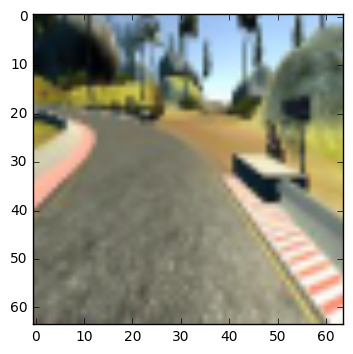

In [199]:
center = input_file['center'][2]
left = input_file['left'][2]
right = input_file['right'][2]

center, left, right = load_image(center), load_image(left), load_image(right)
center, left, right = resize_image(center), resize_image(left), resize_image(right)

plt.imshow(right)

center = center.reshape((1, 64, 64, 3))
left = left.reshape((1, 64, 64, 3))
right = right.reshape((1, 64, 64, 3))


center_angle = float(model.predict(center, batch_size=1))
left_angle = float(model.predict(left, batch_size=1))
right_angle = float(model.predict(right, batch_size=1))


print(center_angle, left_angle, right_angle)

### Without data augmentation

number of images: 14036
image shape: (64, 64, 3)
Sample image


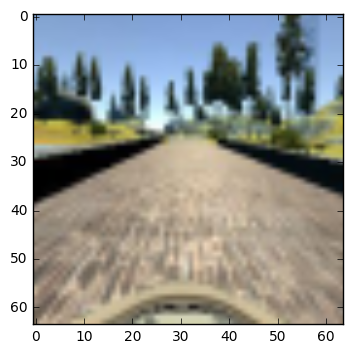

In [123]:
def load_image(imagepath):
    img_rows, img_cols = 64, 64

    imagepath = imagepath.replace(' ', '')
    #image = np.array(Image.open(imagepath))
    image = cv2.imread(imagepath)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (img_rows, img_cols), interpolation=cv2.INTER_AREA)
    return image

input_file = pd.read_csv('driving_log.csv')
input_file = input_file
steering_angle = input_file['steering']

images = np.array([load_image(fname) for fname in input_file['center']])
images_right = np.array([load_image(fname) for fname in input_file['right']])
images_left = np.array([load_image(fname) for fname in input_file['left']])

images = np.concatenate((images, images_right[:3000], images_left[:3000]))
steering_angle = np.concatenate((steering_angle, steering_angle[:3000] - 0.25, steering_angle[:3000] + 0.25))
#images = np.array([np.array(Image.open(fname)) for fname in image_files])

num_images = images.shape[0]
input_shape = images.shape[1:]
print('number of images: %d' % num_images)
print('image shape:', input_shape)

print('Sample image')
plt.imshow(images[0])

In [124]:
from keras.layers.core import Dense, Activation, Flatten, Dropout, Reshape, Lambda
from keras.activations import relu, softmax
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Convolution2D
from keras.models import Sequential

model = Sequential()
model.add(Lambda(lambda x: x / 255. - 0.5, input_shape=(64, 64, 3)))

model.add(Convolution2D(32, 5, 5, border_mode='same'))
model.add(Activation('relu'))

model.add(Convolution2D(16, 3, 3, border_mode='same'))
model.add(Activation('relu'))

model.add(Convolution2D(8, 3, 3, border_mode='same'))
model.add(Activation('relu'))

model.add(Convolution2D(4, 3, 3, border_mode='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid'))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(16))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_6 (Lambda)                (None, 64, 64, 3)     0           lambda_input_6[0][0]             
____________________________________________________________________________________________________
convolution2d_24 (Convolution2D) (None, 64, 64, 32)    2432        lambda_6[0][0]                   
____________________________________________________________________________________________________
activation_39 (Activation)       (None, 64, 64, 32)    0           convolution2d_24[0][0]           
____________________________________________________________________________________________________
convolution2d_25 (Convolution2D) (None, 64, 64, 16)    4624        activation_39[0][0]              
___________________________________________________________________________________________

In [173]:
images.shape

(14036, 64, 64, 3)

In [174]:
from keras.optimizers import Adam

adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss='mean_squared_error', metrics=['accuracy'])
model.fit(images, steering_angle, batch_size=64, nb_epoch=1, validation_split=0.1, shuffle=True)
1
#score = model.evaluate(X_test, y_test)
#print('Test score:', score[0])
#print('Test accuracy:', score[1])

#model.summary()

json_string = model.to_json()
model.save_weights('./model.h5')

import json
with open("model.json", "w") as json_file:
    json_file.write(json_string)

Train on 12632 samples, validate on 1404 samples
Epoch 1/1
12632/12632 [==============================] - 204s - loss: 0.0353 - acc: 0.3452 - val_loss: 0.0551 - val_acc: 0.0000e+00


In [175]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
maxpooling2d_9 (MaxPooling2D)    (None, 32, 32, 3)     0           maxpooling2d_input_2[0][0]       
____________________________________________________________________________________________________
lambda_9 (Lambda)                (None, 32, 32, 3)     0           maxpooling2d_9[0][0]             
____________________________________________________________________________________________________
convolution2d_38 (Convolution2D) (None, 32, 32, 24)    1824        lambda_9[0][0]                   
____________________________________________________________________________________________________
activation_62 (Activation)       (None, 32, 32, 24)    0           convolution2d_38[0][0]           
___________________________________________________________________________________________